### INSTALACION DE LOS PAQUETES NECESARIOS

In [1]:
! pip install -U spacy
! python -m spacy download en
! pip install spacymoji
! pip install emoji
! pip install gensim
! pip install sklearn

  Using cached spacy-3.7.1-cp310-cp310-win_amd64.whl (12.1 MB)
  Using cached srsly-2.4.8-cp310-cp310-win_amd64.whl (481 kB)
  Using cached thinc-8.2.1-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached typer-0.9.0-py3-none-any.whl (45 kB)
  Using cached preshed-3.0.9-cp310-cp310-win_amd64.whl (122 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached pathy-0.10.2-py3-none-any.whl (48 kB)
  Using cached weasel-0.3.3-py3-none-any.whl (49 kB)
  Using cached murmurhash-1.0.10-cp310-cp310-win_amd64.whl (25 kB)
  Using cached pydantic-2.4.2-py3-none-any.whl (395 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl (17 kB)
  Using cached annotated_types-0.6.0-py3-none-any.whl (12 kB)
  Using cached blis-0.7.11-cp310-cp310-win_amd64.whl (6.6 MB)
  Using cached confection-0.1.3-py3-none-any.whl (34 kB)
  Using cached click-8.1.7-py3-none-any.whl (97 kB)
  Using cached cloudpathlib-0.16.0-py3-none-any.whl (45 kB)



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 12.8/12.8 MB 5.5 MB/s eta 0:00:00
[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached spacymoji-3.1.0-py2.py3-none-any.whl (8.5 kB)
  Using cached emoji-2.8.0-py2.py3-none-any.whl (358 kB)



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached gensim-4.3.2-cp310-cp310-win_amd64.whl (24.0 MB)
  Using cached scipy-1.11.3-cp310-cp310-win_amd64.whl (44.1 MB)



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post10-py3-none-any.whl



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import spacy
import emoji
import numpy as np
from tqdm import tqdm

from sklearn.cluster import DBSCAN
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.utils import get_tmpfile

ModuleNotFoundError: No module named 'sklearn'

# 1. Preparación del Dataset

## 1.1. CARGAR FICHERO CSV CON LOS DATOS

In [2]:
datsetPath = '../Datasets/Suicide_Detection.csv'
#datsetPath = '../Datasets/Corto.csv'

data = pd.read_csv(datsetPath)

data.info()
data.head(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


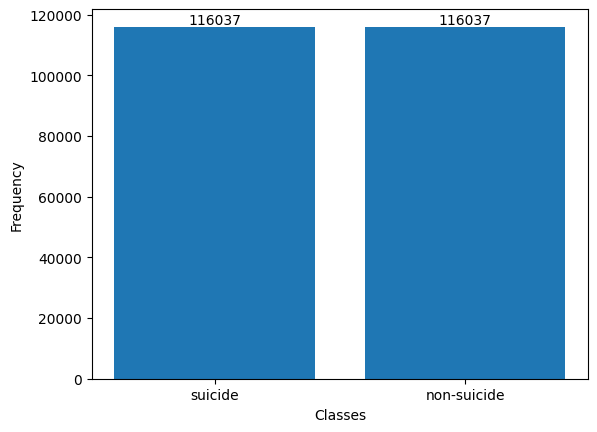

In [3]:
from matplotlib import pyplot as plt

barPlot = plt.bar(data['class'].value_counts().index, data['class'].value_counts())
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.bar_label(barPlot)
plt.show()

## 1.2. SELECCIONAR LA COLUMNA DE TEXTOS (DISCRIMINAR LA CLASE)

In [4]:
textos = []
for instancia in data.values:
    textos.append(instancia[1])

# 2. Pre-proceso
## 2.1. LIMPIEZA Y FORMARTEO DE LOS DATOS

In [5]:
# Cuidado! La ejecución de este bloque con 232074 instancias, toma aproximademente 5 min? 

nlp = spacy.load("en_core_web_sm") # Cargar modelo
nlp.add_pipe("emoji", first=True)

textos_tokenizados = []
for texto in tqdm(textos, desc="Procesando textos"):
    texto = emoji.demojize(texto)  # Emojis a texto
    doc = nlp(texto)
    lexical_tokens = [token.lemma_.lower() for token in doc if len(token.text) > 3 and token.is_alpha]
    textos_tokenizados.append(lexical_tokens)

Procesando textos:   0%|          | 596/232074 [00:58<6:18:33, 10.19it/s] 


KeyboardInterrupt: 

In [ ]:
print(textos[0])
print(textos_tokenizados[0])

## 2.2. Espacio de decisión - VECTORIZACION DE LOS DATOS (DOC2VEC)

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(textos_tokenizados)]
model = Doc2Vec(documents, vector_size=150, window=2, dm=1, epochs=100, workers=4)
# DM siempre a 1 para que sea distributed memory (que tenga en cuenta el contexto)
# Window se puede cambiar pero tener en cuenta que cuanto mayor sea mas coste genera
# Negative: siempre a 0 para que aprenda que palabras son ruido
#Los que se pueden probar para parametro ekorketa:
    # VECTOR SIZE!!!! (tamaño del embedding: dimensiones)
    # Epochs: numero de iteraciones por el dataset
    # Alpha: learning rate inicial
    # Min alpha: El valor de LR con el que va acabar → Igual no poner?
    # Max_vocab_size: Limita el tamaño maximo de las palabras a tener en cuenta (borra las menos frecuentes)

model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

model.save(get_tmpfile("my_doc2vec_model"))

#vector = model.infer_vector(['wife', 'threaten', 'leave', 'wife', 'good', 'because', 'cheat', 'twice', 'lie', 'much', 'that', 'have', 'decide', 'refuse', 'back', 'day', 'begin', 'threaten', 'suicide', 'have', 'tirelessly', 'spend', 'these', 'paat', 'day', 'talk', 'keep'])

#similar_documents = model.dv.most_similar(vector) # Deberia salir 0 porque es el documento del que se han sacado todas las palabras

# 3. Clustering

## 3.1. Aplicando algoritmo DBSCAN (PREDETERMINADO) de la libería sklearn

In [ ]:
document_vectors = [model.infer_vector(doc) for doc in textos_tokenizados]

# Aplicar DBSCAN a los vectores de documentos
dbscan = DBSCAN(eps=2, min_samples=2, leaf_size=5)  # Ajusta los parámetros según tu caso
labels = dbscan.fit_predict(np.array(document_vectors))

# Los resultados del clustering están en 'labels'
print("Etiquetas de clusters:", labels)